In [1]:
#data format library
import h5py
#numpy
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import sys
sys.path.append('./utils')
import operator_calculations as op_calc
import worm_dynamics as worm_dyn
import stats
from scipy.io import loadmat

In [2]:
mat=h5py.File('../data/Foraging_N2/PNAS2011-DataStitched.mat','r')
refs=list(mat['#refs#'].keys())[1:]
tseries_w=[ma.masked_invalid(np.array(mat['#refs#'][ref]).T)[:,:5] for ref in refs]
mat.close()
frameRate=16.
dt=1/frameRate
len_w,dim = tseries_w[0].shape


masked_ts_w = []
for worm in np.arange(len(tseries_w)):
    ts_w = tseries_w[worm]
    ts_w[0] = ma.masked
    ts_w[-1] = ma.masked
    masked_ts_w.append(ts_w)

segments=op_calc.segment_maskedArray(ma.vstack(masked_ts_w),5)
omegas_all=ma.zeros(ma.vstack(masked_ts_w).shape[0])
a3s_all=ma.zeros(ma.vstack(masked_ts_w).shape[0])
for t0,tf in segments:
    phi,omega,a3=worm_dyn.compute_phi_omega_a3(ma.vstack(masked_ts_w),t0,tf)
    omegas_all[t0:tf] = omega
    a3s_all[t0:tf] = a3
omegas_all[omegas_all==0]=ma.masked
a3s_all[a3s_all==0]=ma.masked

eigenworms_matrix = np.loadtxt('../data/Foraging_N2/EigenWorms.csv', delimiter=',').astype(np.float32)
thetas_w = ma.array([ts.dot(eigenworms_matrix[:,:5].T) for ts in masked_ts_w])
thetas_all = ma.vstack(thetas_w)
curvature_all = ma.abs(thetas_all).mean(axis=1)

In [3]:
n_clusters=1000
f = h5py.File('../data/symbol_sequences/labels_{}_clusters.h5'.format(n_clusters),'r')
labels_traj = ma.array(f['labels_traj'],dtype=int)
mask_traj = np.array(f['mask_traj'],dtype=bool)
labels_phspace = ma.array(f['labels_phspace'],dtype=int)
mask_phspace = np.array(f['mask_phspace'],dtype=bool)
centers_phspace = np.array(f['centers_phspace'])
centers_traj = np.array(f['centers_traj'])
f.close()

labels_traj[mask_traj] = ma.masked
labels_phspace[mask_phspace] = ma.masked

In [4]:
n_neighbors=50;min_dist=.05
f = h5py.File('../data/umap_embeddings/umap_n_{:.1f}_d_{:.2f}.h5'.format(n_neighbors,min_dist),'r')
u_all = ma.masked_invalid(f['umap'])
u_all[u_all==0] = ma.masked
f.close()
u = u_all[:-1000]
centers_umap = u_all[-1000:]

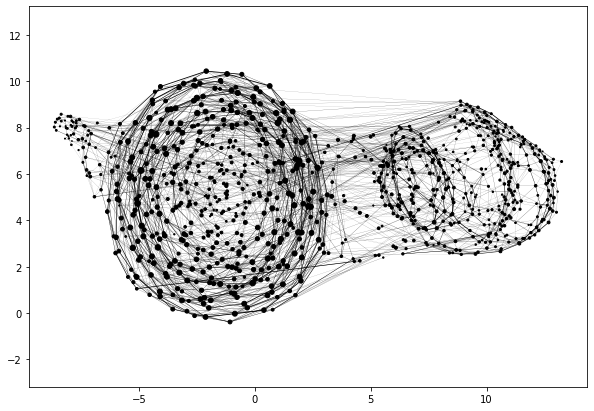

In [6]:
P = op_calc.transition_matrix(labels_traj,lag=1)
pi = op_calc.stationary_distribution(P)
Pd = np.array(P.todense())
plt.figure(figsize=(10,7))
plt.scatter(centers_umap[:,0],centers_umap[:,1],s = 1e4*pi,c='k')
for j in range(P.shape[1]):
    sel = Pd[:,j]>2.5e-2
    for i in np.arange(P.shape[0])[sel]:
        if i==j:
            continue
        else:
            lw = P[i,j]*2
            x_init = centers_umap[j]
            x_final = centers_umap[i]
            X = np.vstack([x_init,x_final])
            plt.plot(X[:,0],X[:,1],lw=lw,c='k')
plt.axis('equal')
# plt.savefig('P_matrix_pmin_0.025.pdf')
plt.show()

In [7]:
f = h5py.File('../data/Foraging_N2/phspace_K_10_m_7.h5','r')
traj_matrix = ma.masked_invalid(f['traj_matrix'])
phspace = ma.array(f['phspace'])
components = np.array(f['modes'])
traj_matrix[traj_matrix==0]=ma.masked
f.close()

In [8]:
n_clusters=1000
frameRate=16.
dt=1/frameRate

kw=0
f = h5py.File('../data/tscales_P/results_{}.h5'.format(kw),'r')
delay_range = np.array(f['delay_range'])
n_clusters = np.array(f['n_clusters'],dtype=int)[0]
f.close()
n_modes=30
n_worms=12
n_shuffle=100

ts_traj_shuffle = np.zeros((n_worms,len(delay_range),n_shuffle))
eigvals_traj_shuffle = np.zeros((n_worms,len(delay_range),n_shuffle))
ts_traj_w = np.zeros((n_worms,len(delay_range),n_modes))
eigvals_traj_w = np.zeros((n_worms,len(delay_range),n_modes))
for kw in range(n_worms):
    f = h5py.File('../data/tscales_P/results_{}.h5'.format(kw),'r')
    ts_traj_shuffle[kw] = np.array(f['ts_traj_shuffle'])
    eigvals_traj_shuffle[kw] = np.array(f['eigvals_traj_shuffle'])
    ts_traj_w[kw] = np.array(f['ts_traj_w'])
    eigvals_traj_w[kw] = np.array(f['eigvals_traj_w'])
    f.close()
    
tscales_shuffle_prop_single = np.vstack([-(delay_range*dt)/np.log(eigvals_traj_shuffle[kw,0,0]) for kw in range(n_worms)])

In [9]:
mean_shuffle,cil_shuffle,ciu_shuffle = stats.bootstrap(tscales_shuffle_prop_single[:,11],n_times=100)

In [10]:
mean,cil,ciu = stats.bootstrap(ts_traj_w[:,11,:],n_times=100)

/Users/costa/opt/anaconda3/lib/python3.8/site-packages/matplotlib/patches.py:1074: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xy = np.asarray(xy)


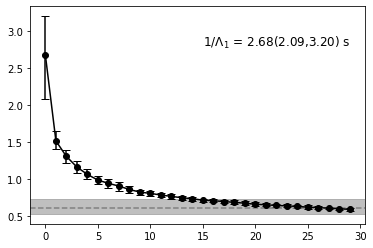

In [11]:
plt.errorbar(np.arange(n_modes),mean,yerr = [mean-cil,ciu-mean],fmt='o-',capsize=4,c='k')
plt.text(15,2.8,'$1/\Lambda_1$ = {:.2f}({:.2f},{:.2f}) s'.format(mean[0],cil[0],ciu[0]),fontsize=12)
plt.axhline(mean_shuffle,c='gray',ls='--')
plt.axhspan(cil_shuffle,ciu_shuffle,color='gray',alpha=.5)
# plt.savefig('tscales_P_1000_clusters_tau_12.pdf')
plt.show()

In [12]:
f = h5py.File('../data/labels_tree/labels_tree.h5','r')
delay = int(np.array(f['delay'])[0])
eigfunctions = np.array(f['eigfunctions'])
final_labels = ma.masked_invalid(np.array(f['final_labels'],dtype=int))
final_labels_mask = np.array(f['final_labels_mask'])
sel = final_labels_mask==1
final_labels[sel] = ma.masked
mlg = f['measures']
measures = []
for k in np.sort(list(mlg.keys())):
    measures.append(np.array(mlg[str(k)]))
labels_tree = np.array(f['labels_tree'])
f.close()

eigfunctions_traj = ma.array(eigfunctions)[final_labels,:]
eigfunctions_traj[final_labels.mask] = ma.masked

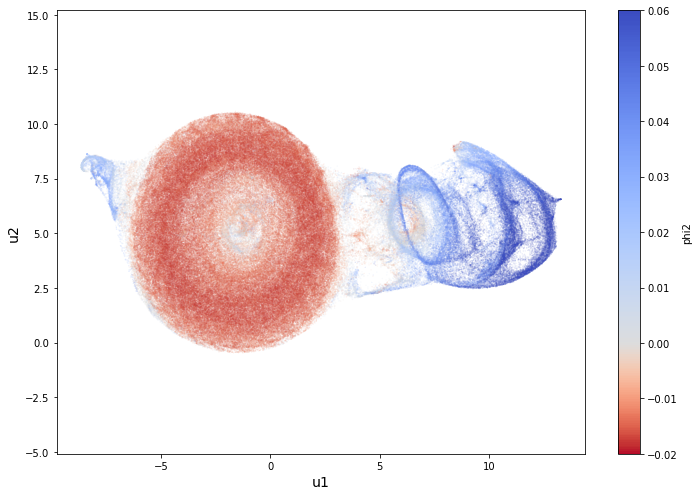

In [13]:
from matplotlib.colors import TwoSlopeNorm
vmin,vmax=-.02,.06
plt.figure(figsize=(10,7))
plt.scatter(u[:,0],u[:,1],s=.003,norm=TwoSlopeNorm(0,vmin=vmin,vmax=vmax),c=eigfunctions_traj[:,1],cmap='coolwarm_r')
plt.colorbar(label = 'phi2')
plt.xlabel('u1',fontsize=14)
plt.ylabel('u2',fontsize=14)
plt.tight_layout()
plt.axis('equal')
# plt.savefig('umap_phi2.png',dpi=500)
plt.show()

In [14]:
mat = loadmat('../data/Foraging_N2/shapes.mat')
theta_ensemble = np.array(mat['theta_ensemble'],dtype=float)
stepper_to_mm = 788
wormCM = ma.array(mat['wormCm'][:,::2,:],dtype=float)/stepper_to_mm
wormCM[wormCM==0] = ma.masked

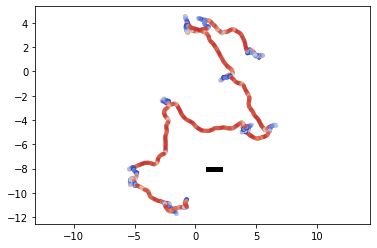

In [15]:
vmin,vmax=-.02,.05
len_w = len(tseries_w[0])
kw=8
t0 = int(5*frameRate*60)
tf=int(15*frameRate*60)
plt.scatter(wormCM[kw][t0:tf,0],wormCM[kw][t0:tf,1],c=eigfunctions_traj[kw*len_w:(kw+1)*len_w,1][t0:tf],s=10,alpha=.1,
            cmap='coolwarm_r',norm=TwoSlopeNorm(0,vmin=vmin,vmax=vmax))
plt.axis('equal')
plt.plot([1,2],[-8,-8],c='k',lw=5)
# plt.savefig('centroid_example1.pdf')
plt.show()

In [16]:
from lmfit import minimize, Parameters, Parameter, report_fit

def fit_tscales(x,y,b0=10,d0=50):
    
    def fcn2(params,x,data):
        a=params['a'].value
        b=params['b'].value
        c=params['c'].value
        d=params['d'].value
        #Fits the drift

        return (a*np.exp(-x/b) + c * np.exp(-x/d) - data)

    params = Parameters()
    params.add('a',   value= 1)
    params.add('b', value= b0,min=0)
    params.add('c', value= 1)
    params.add('d', value= d0,min=0)

    # do fit, here with leastsq model
    result = minimize(fcn2, params, args=(x,y))
    
    p1 = result.params['a'].value
    p2 = result.params['b'].value
    p3 = result.params['c'].value
    p4 = result.params['d'].value
    tscales = np.array([p2,p4])
    stderrs = np.array([result.params['b'].stderr,result.params['d'].stderr])
    
    return p1,p2,p3,p4,tscales,stderrs

def func2(x, a, b, c, d):
    return a * np.exp(-x/b) + c * np.exp(-x/d) 

In [17]:
def state_lifetime(states):
    durations=[]
    for state in np.sort(np.unique(states.compressed())):
        gaps = states==state
        gaps_boundaries = np.where(np.abs(np.diff(np.concatenate([[False], gaps, [False]]))))[0].reshape(-1, 2)
        durations.append(np.hstack(np.diff(gaps_boundaries)))
    return durations

In [18]:
kmeans_labels = labels_tree[0,:]
cluster_traj = ma.copy(final_labels)
cluster_traj[~final_labels.mask] = ma.array(kmeans_labels)[final_labels[~final_labels.mask]]
cluster_traj[final_labels.mask] = ma.masked
cluster_traj_w = cluster_traj.reshape((n_worms,len_w))

In [19]:
dts_w=[]
for kw,labels in enumerate(cluster_traj_w):
    dts = np.hstack(state_lifetime(labels))*dt
    dts_w.append(dts)

In [20]:
def get_errorbar_dist(lifetimes_w,t0,tf):
    all_lt = np.hstack(lifetimes_w)
    x,y = stats.complementary_cumulative_dist(all_lt,(t0,tf))
    y_all = np.array([np.mean(y[x==x_unique]) for x_unique in np.unique(x)])
    x_all = np.sort(np.unique(x))
    
    dict_y = {}
    for x_ in x_all:
        dict_y[x_] = []

    for k in range(100):
        x,y = stats.cumulative_dist(np.hstack(np.random.choice(lifetimes_w,len(lifetimes_w))),(t0,tf))
        y = 1-np.array([np.mean(y[x==x_unique]) for x_unique in np.unique(x)])
        x = np.sort(np.unique(x))
        for kx in range(len(y)):
            dict_y[x[kx]].append(y[kx])
        if k%10==0:
            print(k)
            
    y_errorbars = np.zeros((len(dict_y.keys()),3))
    for kx,x_ in enumerate(x_all):
        values = np.array(dict_y[x_])
        values = values[values>0]
        cil = np.percentile(values,2.5)
        ciu = np.percentile(values,97.5)
        y_errorbars[kx] = [y_all[kx],cil,ciu]
    return x_all,y_errorbars

In [21]:
t0,tf = delay*dt,1000
all_lt = np.hstack(dts_w)
x,y = stats.complementary_cumulative_dist(all_lt,(t0,tf))
y_all = np.array([np.mean(y[x==x_unique]) for x_unique in np.unique(x)])
x_all = np.sort(np.unique(x))

p1,p2,p3,p4,tscales,stderrs = fit_tscales(x_all,y_all,b0=1,d0=40)
params_all = np.array([p1,p2,p3,p4])
sorted_indices = np.argsort(tscales)[::-1]
tscales_all = tscales[sorted_indices]

dict_y = {}
for x_ in x_all:
    dict_y[x_] = []

In [22]:
tscales_bootstrap = []
params_bootstrap = []
rates_bootstrap = []
for k in range(5000):
    x,y = stats.complementary_cumulative_dist(np.hstack(np.random.choice(dts_w,len(dts_w))),(t0,tf))
    y = np.array([np.mean(y[x==x_unique]) for x_unique in np.unique(x)])
    x = np.sort(np.unique(x))
    p1,p2,p3,p4,tscales,stderrs = fit_tscales(x,y,b0=1,d0=25)
    params_bootstrap.append(np.array([p1,p2,p3,p4]))
    sorted_indices = np.argsort(tscales)[::-1]
    tscales = tscales[sorted_indices]
    tscales_bootstrap.append(tscales)
    rates_bootstrap.append((1/tscales).sum())
    for kx in range(len(y)):
        dict_y[x[kx]].append(y[kx])

<ipython-input-22-4c02a93f574d>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x,y = stats.complementary_cumulative_dist(np.hstack(np.random.choice(dts_w,len(dts_w))),(t0,tf))


In [23]:
y_errorbars = np.zeros((len(dict_y.keys()),3))
for kx,x_ in enumerate(x_all):
    values = np.array(dict_y[x_])
    values = values[values>0]
    cil = np.percentile(values,2.5)
    ciu = np.percentile(values,97.5)
    y_errorbars[kx] = [y_all[kx],cil,ciu]

In [24]:
tscales_cil = np.percentile(np.vstack(tscales_bootstrap),2.5,axis=0)
tscales_ciu = np.percentile(np.vstack(tscales_bootstrap),97.5,axis=0)

rates_cil = np.percentile(np.vstack(rates_bootstrap),2.5,axis=0)
rates_ciu = np.percentile(np.vstack(rates_bootstrap),97.5,axis=0)

params_cil = np.percentile(params_bootstrap,2.5,axis=0)
params_ciu = np.percentile(params_bootstrap,97.5,axis=0)

p1,p2,p3,p4 = params_all
curvey = func2(x_all,p1,p2,p3,p4)

p1,p2,p3,p4 = params_cil
curvey_cil = func2(x_all,p1,p2,p3,p4)

p1,p2,p3,p4 = params_ciu
curvey_ciu = func2(x_all,p1,p2,p3,p4)

In [25]:
lambda_rec = 1/(1/tscales_all[0]+1/tscales_all[1])
lambda_rec_cil = np.percentile(1/np.sum(1/np.vstack(tscales_bootstrap),axis=1),2.5)
lambda_rec_ciu = np.percentile(1/np.sum(1/np.vstack(tscales_bootstrap),axis=1),97.5)

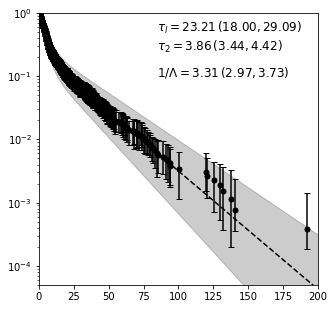

In [26]:
plt.figure(figsize=(5,5))
plt.errorbar(x_all,y_errorbars[:,0],yerr = [y_errorbars[:,0]-y_errorbars[:,1],y_errorbars[:,2]-y_errorbars[:,0]],fmt='o',ms=5,capsize=3,c='k')
plt.plot(x_all,curvey,c='k',ls='--')
plt.fill_between(x_all,curvey_cil,curvey_ciu,color='k',alpha=.2)
plt.ylim(5e-5,1)
plt.yscale('log')
plt.xlim(0,200)
plt.text(85,.5,r'$\tau_l = {:.2f}\,({:.2f},{:.2f})$'.format(tscales_all[0],tscales_cil[0],tscales_ciu[0]),fontsize=12)
plt.text(85,.25,r'$\tau_2 = {:.2f}\,({:.2f},{:.2f})$'.format(tscales_all[1],tscales_cil[1],tscales_ciu[1]),fontsize=12)
plt.text(85,.1,r'$1/\Lambda = {:.2f}\,({:.2f},{:.2f})$'.format(lambda_rec,lambda_rec_cil,lambda_rec_ciu),fontsize=12)
# plt.savefig('dwell_times_biexp_worm_all_worms_2_states_Pierce-Shimomura_{}_{}_delay_{}_with_errorbars.pdf'.format(t0,tf,delay))
plt.show()

In [27]:
lambda_rec,lambda_rec_cil,lambda_rec_ciu

(3.3127067040076255, 2.969547294151116, 3.727394572389021)

In [28]:
colors_states_ = ['#951622','#E30613','#F06600','#F09900','#312783','#1F77B4','#009FE3']
final_states = ['fast_curved','fast_straight','slow_dorsal','slow_ventral','dorsal turns','reversals','turns']
subdiv_dict = {'run':['slow','fast'],'fast':['fast_curved','fast_straight'],'slow':['dorsal','ventral'],
              'pirouette':['dorsal','ventral'],'ventral pirouettes':['reversals','turns']}

In [29]:
colors_state_stage = [['#1F77B4','#E30613'],
                     ['#1F77B4','#F06600','#E30613'],
                      ['#1F77B4','#F06600','#951622','#E30613'],
                     ['#1F77B4','#951622','#E30613','#F06600','#F09900'],
                     ['#951622','#E30613','#F06600','#F09900','#312783','#1F77B4'],
                     ['#951622','#E30613','#F06600','#F09900','#312783','#1F77B4','#009FE3']]

1
2
1
0
5


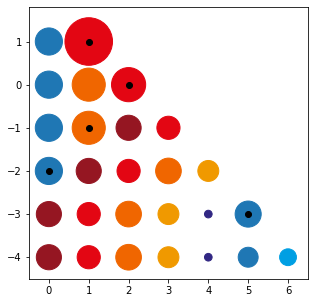

In [30]:
plt.figure(figsize=(5,5))
plt.scatter(np.arange(2),np.ones(2),s=3000*np.array(measures[0]),c=colors_state_stage[0])
for k in range(1,6):
    idx = np.argmax(measures[k-1])
    print(idx)
    plt.scatter(np.arange(k+2),np.ones(k+2)-k,s=3000*np.array(measures[k]),c=colors_state_stage[k])
    plt.scatter(idx,-k+2,c='k')
plt.xlim(-.5,6.5)
plt.ylim(-4.5,1.8)
# plt.savefig('subdivs.pdf')
plt.show()

In [31]:
kmeans_labels = labels_tree[5,:]
cluster_traj = ma.copy(final_labels)
cluster_traj[~final_labels.mask] = ma.masked_invalid(kmeans_labels)[final_labels[~final_labels.mask]]
cluster_traj[final_labels.mask] = ma.masked

In [32]:
dts_state = np.array(state_lifetime(cluster_traj[::delay]))*dt*delay

<ipython-input-32-0bca41c9f3b4>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dts_state = np.array(state_lifetime(cluster_traj[::delay]))*dt*delay


In [33]:
mean_tau,cil_tau,ciu_tau = stats.bootstrap(np.hstack(dts_state),n_times=1000)

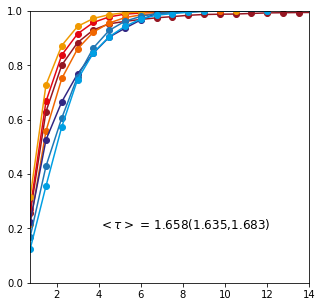

In [34]:
plt.figure(figsize=(5,5))
for ks in range(7):
    x,y = stats.cumulative_dist(dts_state[ks],(0,100))
    y = np.array([np.mean(y[x==x_unique]) for x_unique in np.unique(x)])
    x = np.sort(np.unique(x))
    plt.plot(x,y,marker='o',c=colors_states_[ks])
plt.xlim(delay*dt,14)
plt.ylim(0,1)
plt.text(4,.2,r'$<\tau>$ = {:.3f}({:.3f},{:.3f})'.format(mean_tau,cil_tau[0],ciu_tau[0]),fontsize=12)
plt.show()

In [35]:
compressed_traj=[]
cluster_traj_nan = ma.filled(cluster_traj,10)
for k in range(len(cluster_traj)-1):
    if cluster_traj_nan[k+1]!=cluster_traj_nan[k]:
        compressed_traj.append(cluster_traj_nan[k])
compressed_traj = ma.hstack(compressed_traj)
compressed_traj[compressed_traj==10] = ma.masked

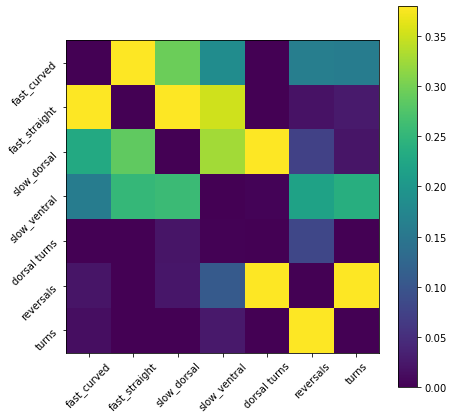

In [36]:
Pc = op_calc.transition_matrix(compressed_traj,lag=1)
im = op_calc.stationary_distribution(Pc)
plt.figure(figsize=(7,7))
plt.imshow(Pc.todense().T,vmax=.38)
plt.colorbar()
plt.yticks(np.arange(Pc.shape[0]),final_states,rotation=45)
plt.xticks(np.arange(Pc.shape[0]),final_states,rotation=45)
plt.show()

In [37]:
def polygon(sides, radius=1, rotation=0, translation=None):
    one_segment = np.pi * 2 / sides

    points = [
        (np.sin(one_segment * i + rotation) * radius,
         np.cos(one_segment * i + rotation) * radius)
        for i in range(sides)]

    if translation:
        points = [[sum(pair) for pair in zip(point, translation)]
                  for point in points]

    return points

In [38]:
from matplotlib import patches
def draw_curved_arrow(idx0,point0,point1,hw,angle,color_array):
    style = "Simple, tail_width={}, head_width={}, head_length={}".format(hw,5*hw,7.5*hw)
    kw = dict(arrowstyle=style, color=color_array[idx0])
    a = patches.FancyArrowPatch(point0, point1,
                                 connectionstyle="arc3,rad={}".format(angle), **kw)
    plt.gca().add_patch(a)

In [39]:
def get_angle_array(idx,n_states):
    idx=0
    angle_array = np.zeros(n_states)
    for k in range(3):
        angle_array[idx-k-1]=.3*kx+k*.05
        if idx+k>n_states-1:
            angle_array[k-n_states+idx] = -.3*kx-k*.05
        else:
            angle_array[idx+k]=-.35*kx-k*.01
    return angle_array

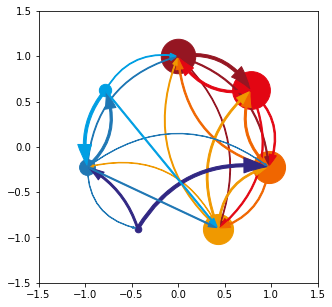

In [40]:
n_states=7
points = polygon(n_states)

Pc_d = Pc.todense()
Pc_d[Pc_d<5e-2]=0
plt.figure(figsize=(5,5))
for k in range(n_states):
    plt.scatter(points[k][0],points[k][1],s=5000*im[k],c=colors_states_[k])
kx=-1
for idx in range(n_states):
    angle_array = get_angle_array(idx,n_states)*kx
    trans_indices = np.arange(0,n_states)
    trans_indices = trans_indices[trans_indices!=idx]
    for kj,j in enumerate(trans_indices):
        
        draw_curved_arrow(idx,points[idx],points[j],5*Pc_d[idx,j],angle_array[kj],colors_states_)
    kx=kx*-1
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
# plt.savefig('trans_graph_7_states_min_p_0.05.pdf')
plt.show()